# Delta Hedging with Non-Constant Volatility Models

## Project Overview

This project explores the impact of non-constant volatility on delta hedging strategies. Classical Black-Scholes delta hedging assumes constant volatility σ, but real markets exhibit time-varying volatility due to various factors including market sentiment, economic events, and volatility clustering.

### Objectives:
1. **Simulate stock paths** using different volatility models
2. **Implement delta hedging strategies** for each model
3. **Compare profit distributions** across different volatility assumptions
4. **Analyze the impact** of stochastic volatility on hedging effectiveness

### Models Implemented:
- **Custom Sigma Model**: Random volatility selection at each time step
- **GARCH(1,1)**: Volatility clustering model
- **Heston Model**: Stochastic volatility with mean reversion
- **SABR Model**: Popular in interest rate and FX markets

## Mathematical Background

### Black-Scholes Framework

The European call option price under Black-Scholes:

$$C(S, K, \sigma, t, r) = S \cdot \Phi(d_1) - K e^{-rt} \cdot \Phi(d_2)$$

where:
$$d_1 = \frac{\ln(S/K) + (r + \frac{1}{2}\sigma^2)t}{\sigma \sqrt{t}}, \quad d_2 = d_1 - \sigma \sqrt{t}$$

The **delta** (price sensitivity):
$$\Delta = \frac{\partial C}{\partial S} = \Phi(d_1)$$

### Delta Hedging Strategy

- **Portfolio**: Short 1 call option, long Δ shares, cash position
- **Rebalancing**: Adjust share position to match current delta at each time step
- **Profit**: Final portfolio value minus initial option premium

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

## Black-Scholes Functions

In [26]:
def delta_call(S, K, sigma, t, r=0.02):
    """
    Calculate delta of a European call option using Black-Scholes formula
    
    Parameters:
    S (float): Current stock price
    K (float): Strike price
    sigma (float): Volatility
    t (float): Time to expiration
    r (float): Risk-free rate
    
    Returns:
    float: Delta value
    """
    if t <= 0 or sigma <= 0:
        return 1.0 if S > K else 0.0
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma * np.sqrt(t))
    return norm.cdf(d1)

def bs_call_price(S, K, sigma, t, r=0.02):
    """
    Calculate European call option price using Black-Scholes formula
    
    Parameters:
    S (float): Current stock price
    K (float): Strike price
    sigma (float): Volatility
    t (float): Time to expiration
    r (float): Risk-free rate
    
    Returns:
    float: Option price
    """
    if t <= 0:
        return max(S - K, 0)
    if sigma <= 0:
        return max(S - K * np.exp(-r*t), 0)
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    
    return S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)

def vega_call(S, K, sigma, t, r=0.02):
    """
    Calculate vega of a European call option
    
    Parameters:
    S (float): Current stock price
    K (float): Strike price
    sigma (float): Volatility
    t (float): Time to expiration
    r (float): Risk-free rate
    
    Returns:
    float: Vega value
    """
    if t <= 0 or sigma <= 0:
        return 0.0
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma * np.sqrt(t))
    return S * norm.pdf(d1) * np.sqrt(t)

## Volatility Model 1: Custom Sigma Model

This model randomly selects volatility at each time step from a discrete distribution.

In [27]:
def simulate_custom_sigma_paths(S0, mu, r, T, N, n_paths, sigma_choices=[0.2, 0.3, 0.45], 
                               sigma_probs=[0.5, 0.3, 0.2]):
    """
    Simulate stock paths with custom random volatility selection
    
    Parameters:
    S0 (float): Initial stock price
    mu (float): Drift parameter
    r (float): Risk-free rate
    T (float): Time horizon
    N (int): Number of time steps
    n_paths (int): Number of simulation paths
    sigma_choices (list): Available volatility values
    sigma_probs (list): Probabilities for each volatility choice
    
    Returns:
    tuple: (stock_paths, volatility_paths)
    """
    dt = T / N
    stock_paths = []
    volatility_paths = []
    
    for _ in range(n_paths):
        # Initialize arrays
        S = [S0]
        sigmas = []
        
        for _ in range(N):
            # Select random volatility
            sigma = np.random.choice(sigma_choices, p=sigma_probs)
            sigmas.append(sigma)
            
            # Generate stock price increment
            dW = np.random.normal(0, np.sqrt(dt))
            dS = (mu - 0.5 * sigma**2) * dt + sigma * dW
            S_next = S[-1] * np.exp(dS)
            S.append(S_next)
        
        stock_paths.append(S)
        volatility_paths.append(sigmas)
    
    return np.array(stock_paths), np.array(volatility_paths)

## Volatility Model 2: GARCH(1,1) Model
GARCH models capture volatility clustering - the tendency for high volatility periods to be followed by high volatility.

In [28]:
def simulate_garch_paths(S0, mu, r, T, N, n_paths, sigma0=0.2, omega=0.0001, alpha=0.1, beta=0.8):
    """
    Simulate stock paths using GARCH(1,1) volatility model
    
    The GARCH(1,1) model: σ²(t) = ω + α·ε²(t-1) + β·σ²(t-1)
    
    Parameters:
    S0 (float): Initial stock price
    mu (float): Drift parameter
    r (float): Risk-free rate
    T (float): Time horizon
    N (int): Number of time steps
    n_paths (int): Number of simulation paths
    sigma0 (float): Initial volatility
    omega (float): Long-run average volatility
    alpha (float): Reaction to new information
    beta (float): Persistence of volatility
    
    Returns:
    tuple: (stock_paths, volatility_paths)
    """
    dt = T / N
    stock_paths = []
    volatility_paths = []
    
    for _ in range(n_paths):
        S = [S0]
        sigmas = [sigma0]
        sigma_sq = sigma0**2
        
        for _ in range(N):
            # Generate random shock
            z = np.random.normal(0, 1)
            
            # Update variance using GARCH formula
            sigma_sq = omega + alpha * z**2 + beta * sigma_sq
            sigma_t = np.sqrt(max(sigma_sq, 1e-6))  # Ensure positive volatility
            
            # Generate stock price increment
            dS = (mu - 0.5 * sigma_sq) * dt + sigma_t * np.sqrt(dt) * z
            S_next = S[-1] * np.exp(dS)
            
            S.append(S_next)
            sigmas.append(sigma_t)
        
        stock_paths.append(S)
        volatility_paths.append(sigmas)
    
    return np.array(stock_paths), np.array(volatility_paths)

## Volatility Model 3: Heston Stochastic Volatility Model
The Heston model treats variance as a mean-reverting stochastic process.

In [29]:
def simulate_heston_paths(S0, v0, mu, r, kappa, theta, xi, rho, T, N, n_paths):
    """
    Simulate stock paths using Heston stochastic volatility model
    
    Stock: dS = μS dt + √v S dW₁
    Variance: dv = κ(θ - v) dt + ξ√v dW₂
    where dW₁ and dW₂ have correlation ρ
    
    Parameters:
    S0 (float): Initial stock price
    v0 (float): Initial variance
    mu (float): Drift parameter
    r (float): Risk-free rate
    kappa (float): Mean reversion speed
    theta (float): Long-term variance
    xi (float): Volatility of volatility
    rho (float): Correlation between price and volatility
    T (float): Time horizon
    N (int): Number of time steps
    n_paths (int): Number of simulation paths
    
    Returns:
    tuple: (stock_paths, volatility_paths)
    """
    dt = T / N
    stock_paths = []
    volatility_paths = []
    
    for _ in range(n_paths):
        S = [S0]
        v = [v0]
        sigmas = [np.sqrt(v0)]
        
        for _ in range(N):
            # Generate correlated random numbers
            z1 = np.random.normal(0, 1)
            z2 = np.random.normal(0, 1)
            dW_S = z1
            dW_v = rho * z1 + np.sqrt(1 - rho**2) * z2
            
            # Current variance (ensure non-negative)
            v_current = max(v[-1], 0)
            sqrt_v = np.sqrt(v_current)
            
            # Update variance using Heston SDE
            v_next = v_current + kappa * (theta - v_current) * dt + xi * sqrt_v * np.sqrt(dt) * dW_v
            v_next = max(v_next, 0)  # Ensure non-negative variance
            
            # Update stock price using Heston SDE
            dS = (mu - 0.5 * v_current) * dt + sqrt_v * np.sqrt(dt) * dW_S
            S_next = S[-1] * np.exp(dS)
            
            S.append(S_next)
            v.append(v_next)
            sigmas.append(np.sqrt(v_next))
        
        stock_paths.append(S)
        volatility_paths.append(sigmas)
    
    return np.array(stock_paths), np.array(volatility_paths)

## Volatility Model 4: SABR Model

The SABR model is popular for modeling interest rates and FX volatility.

In [30]:
def simulate_sabr_paths(F0, alpha0, beta, nu, rho, T, N, n_paths):
    """
    Simulate forward rate paths using SABR stochastic volatility model
    
    Forward: dF = α F^β dW₁
    Volatility: dα = ν α dW₂
    where dW₁ and dW₂ have correlation ρ
    
    Parameters:
    F0 (float): Initial forward rate/price
    alpha0 (float): Initial volatility
    beta (float): Elasticity parameter (0 ≤ β ≤ 1)
    nu (float): Volatility of volatility
    rho (float): Correlation
    T (float): Time horizon
    N (int): Number of time steps
    n_paths (int): Number of simulation paths
    
    Returns:
    tuple: (forward_paths, volatility_paths)
    """
    dt = T / N
    forward_paths = []
    volatility_paths = []
    
    for _ in range(n_paths):
        F = [F0]
        alpha = [alpha0]
        
        for _ in range(N):
            # Generate correlated random numbers
            z1 = np.random.normal(0, 1)
            z2 = np.random.normal(0, 1)
            dW_F = z1
            dW_alpha = rho * z1 + np.sqrt(1 - rho**2) * z2
            
            # Update volatility
            alpha_current = max(alpha[-1], 1e-6)  # Ensure positive
            alpha_next = alpha_current * np.exp(nu * np.sqrt(dt) * dW_alpha - 0.5 * nu**2 * dt)
            
            # Update forward rate
            F_current = max(F[-1], 1e-6)  # Ensure positive
            F_next = F_current + alpha_current * (F_current**beta) * np.sqrt(dt) * dW_F
            F_next = max(F_next, 1e-6)  # Ensure positive
            
            F.append(F_next)
            alpha.append(alpha_next)
        
        forward_paths.append(F)
        volatility_paths.append(alpha)
    
    return np.array(forward_paths), np.array(volatility_paths)

## Delta Hedging Implementation

In [31]:
def delta_hedge_simulation(stock_paths, volatility_paths, K, r, T, verbose=False):
    """
    Simulate delta hedging strategy for given stock paths and volatilities
    
    Parameters:
    stock_paths (array): Simulated stock price paths
    volatility_paths (array): Corresponding volatility paths
    K (float): Strike price of option to hedge
    r (float): Risk-free rate
    T (float): Time to expiration
    verbose (bool): Print progress information
    
    Returns:
    list: Hedging profits for each path
    """
    N = stock_paths.shape[1] - 1  # Number of time steps
    dt = T / N
    profits = []
    
    for i, (stock_path, vol_path) in enumerate(zip(stock_paths, volatility_paths)):
        if verbose and i % 100 == 0:
            print(f"Processing path {i+1}/{len(stock_paths)}")
        
        # Initialize portfolio
        cash = 0.0
        shares_held = 0.0
        
        # Get initial option price (premium received for selling the option)
        initial_volatility = vol_path[0] if len(vol_path) > 0 else 0.2
        initial_option_price = bs_call_price(stock_path[0], K, initial_volatility, T, r)
        
        # Delta hedging simulation
        for step in range(N):
            S_current = stock_path[step]
            sigma_current = vol_path[step] if step < len(vol_path) else vol_path[-1]
            time_to_expiry = T - step * dt
            
            # Calculate current delta
            current_delta = delta_call(S_current, K, sigma_current, time_to_expiry, r)
            
            # Rebalance portfolio
            shares_to_buy = current_delta - shares_held
            cash -= shares_to_buy * S_current  # Buy/sell shares
            cash *= np.exp(r * dt)  # Earn interest on cash
            shares_held = current_delta
        
        # Final portfolio value at expiration
        final_stock_price = stock_path[-1]
        final_option_payoff = max(final_stock_price - K, 0)
        final_portfolio_value = shares_held * final_stock_price + cash
        
        # Calculate profit: initial premium + final portfolio value - option payoff
        profit = initial_option_price + final_portfolio_value - final_option_payoff
        profits.append(profit)
    
    return profits

## Visualization Functions

In [32]:
def plot_stock_paths(paths, title, n_display=10):
    """
    Plot sample stock price paths
    
    Parameters:
    paths (array): Stock price paths
    title (str): Plot title
    n_display (int): Number of paths to display
    """
    plt.figure(figsize=(12, 7))
    
    # Plot subset of paths for clarity
    display_indices = np.random.choice(len(paths), min(n_display, len(paths)), replace=False)
    
    for i in display_indices:
        plt.plot(paths[i], alpha=0.7, linewidth=1.5)
    
    plt.title(f'{title} - Sample Stock Paths', fontsize=16, fontweight='bold')
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Stock Price ($)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_volatility_paths(vol_paths, title, n_display=10):
    """
    Plot sample volatility paths
    
    Parameters:
    vol_paths (array): Volatility paths
    title (str): Plot title
    n_display (int): Number of paths to display
    """
    plt.figure(figsize=(12, 7))
    
    # Plot subset of paths for clarity
    display_indices = np.random.choice(len(vol_paths), min(n_display, len(vol_paths)), replace=False)
    
    for i in display_indices:
        plt.plot(vol_paths[i], alpha=0.7, linewidth=1.5)
    
    plt.title(f'{title} - Sample Volatility Paths', fontsize=16, fontweight='bold')
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Volatility', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_profit_distribution(profits, model_name, show_stats=True):
    """
    Plot profit distribution histogram with statistics
    
    Parameters:
    profits (list): List of profits
    model_name (str): Name of the volatility model
    show_stats (bool): Whether to display statistics
    """
    plt.figure(figsize=(12, 7))
    
    # Create histogram
    n_bins = min(30, len(profits) // 10)
    counts, bins, patches = plt.hist(profits, bins=n_bins, alpha=0.7, density=True, 
                                   color='skyblue', edgecolor='black', linewidth=0.5)
    
    # Add KDE curve
    from scipy.stats import gaussian_kde
    if len(profits) > 1:
        kde = gaussian_kde(profits)
        x_range = np.linspace(min(profits), max(profits), 300)
        plt.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    # Add mean and median lines
    mean_profit = np.mean(profits)
    median_profit = np.median(profits)
    
    plt.axvline(mean_profit, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: ${mean_profit:.2f}')
    plt.axvline(median_profit, color='green', linestyle='--', linewidth=2, 
                label=f'Median: ${median_profit:.2f}')
    plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5, 
                label='Break-even')
    
    plt.title(f'Delta Hedging Profit Distribution - {model_name}', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Profit ($)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    if show_stats:
        # Add statistics text box
        stats_text = f'''Statistics:
Mean: ${np.mean(profits):.2f}
Std Dev: ${np.std(profits):.2f}
Min: ${np.min(profits):.2f}
Max: ${np.max(profits):.2f}
Profitable: {np.sum(np.array(profits) > 0) / len(profits) * 100:.1f}%'''
        
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.8), fontsize=9)
    
    plt.tight_layout()
    plt.show()

def compare_profit_distributions(profit_dict):
    """
    Compare profit distributions across different models
    
    Parameters:
    profit_dict (dict): Dictionary with model names as keys and profits as values
    """
    plt.figure(figsize=(15, 10))
    
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'plum', 'orange']
    
    for i, (model_name, profits) in enumerate(profit_dict.items()):
        plt.hist(profits, bins=25, alpha=0.6, density=True, 
                label=f'{model_name} (μ=${np.mean(profits):.2f})', 
                color=colors[i % len(colors)])
    
    plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    plt.title('Comparison of Delta Hedging Profit Distributions', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Profit ($)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Main Simulation and Analysis

In [33]:
np.random.seed(1205)

# Model parameters
S0 = 100        # Initial stock price
K = 100         # Strike price (at-the-money option)
T = 1.0         # Time to expiration (1 year)
N = 252         # Number of time steps (daily)
n_paths = 1000  # Number of simulation paths
mu = 0.08       # Drift parameter
r = 0.02        # Risk-free rate

print("=" * 60)
print("DELTA HEDGING WITH NON-CONSTANT VOLATILITY ANALYSIS")
print("=" * 60)
print(f"Parameters:")
print(f"  Initial Stock Price (S0): ${S0}")
print(f"  Strike Price (K): ${K}")
print(f"  Time to Expiration (T): {T} year")
print(f"  Time Steps (N): {N}")
print(f"  Simulation Paths: {n_paths}")
print(f"  Drift (μ): {mu:.1%}")
print(f"  Risk-free Rate (r): {r:.1%}")
print("=" * 60)

DELTA HEDGING WITH NON-CONSTANT VOLATILITY ANALYSIS
Parameters:
  Initial Stock Price (S0): $100
  Strike Price (K): $100
  Time to Expiration (T): 1.0 year
  Time Steps (N): 252
  Simulation Paths: 1000
  Drift (μ): 8.0%
  Risk-free Rate (r): 2.0%


## Model 1: Custom Sigma Model

\n1. CUSTOM SIGMA MODEL
----------------------------------------


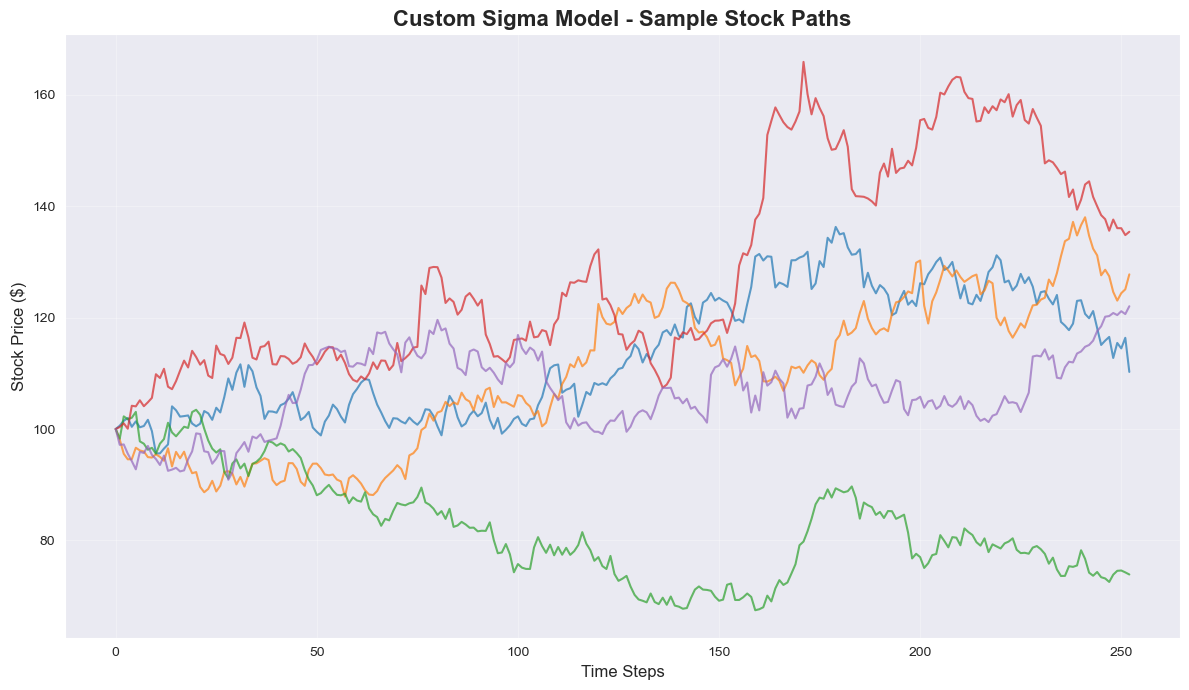

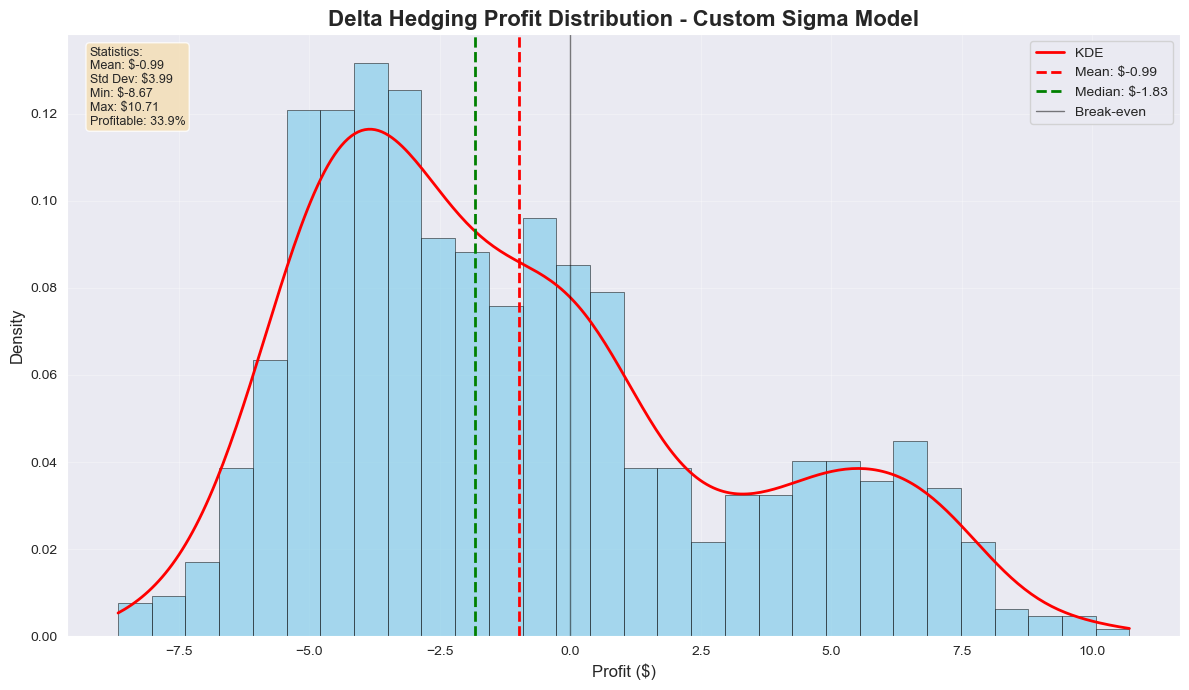

Custom Sigma Results:
  Mean Profit: $-0.99
  Std Deviation: $3.99
  Profitable Outcomes: 33.9%


In [34]:
print("\\n1. CUSTOM SIGMA MODEL")
print("-" * 40)
np.random.seed(1205)
# Simulate custom sigma paths
custom_paths, custom_vols = simulate_custom_sigma_paths(
    S0=S0, mu=mu, r=r, T=T, N=N, n_paths=n_paths,
    sigma_choices=[0.2, 0.3, 0.45], sigma_probs=[0.5, 0.3, 0.2]
)

# Plot sample paths
plot_stock_paths(custom_paths, "Custom Sigma Model", n_display=5)

# Calculate hedging profits
custom_profits = delta_hedge_simulation(custom_paths, custom_vols, K, r, T)

# Plot profit distribution
plot_profit_distribution(custom_profits, "Custom Sigma Model")

print(f"Custom Sigma Results:")
print(f"  Mean Profit: ${np.mean(custom_profits):.2f}")
print(f"  Std Deviation: ${np.std(custom_profits):.2f}")
print(f"  Profitable Outcomes: {np.sum(np.array(custom_profits) > 0) / len(custom_profits) * 100:.1f}%")


2. GARCH(1,1) MODEL
----------------------------------------


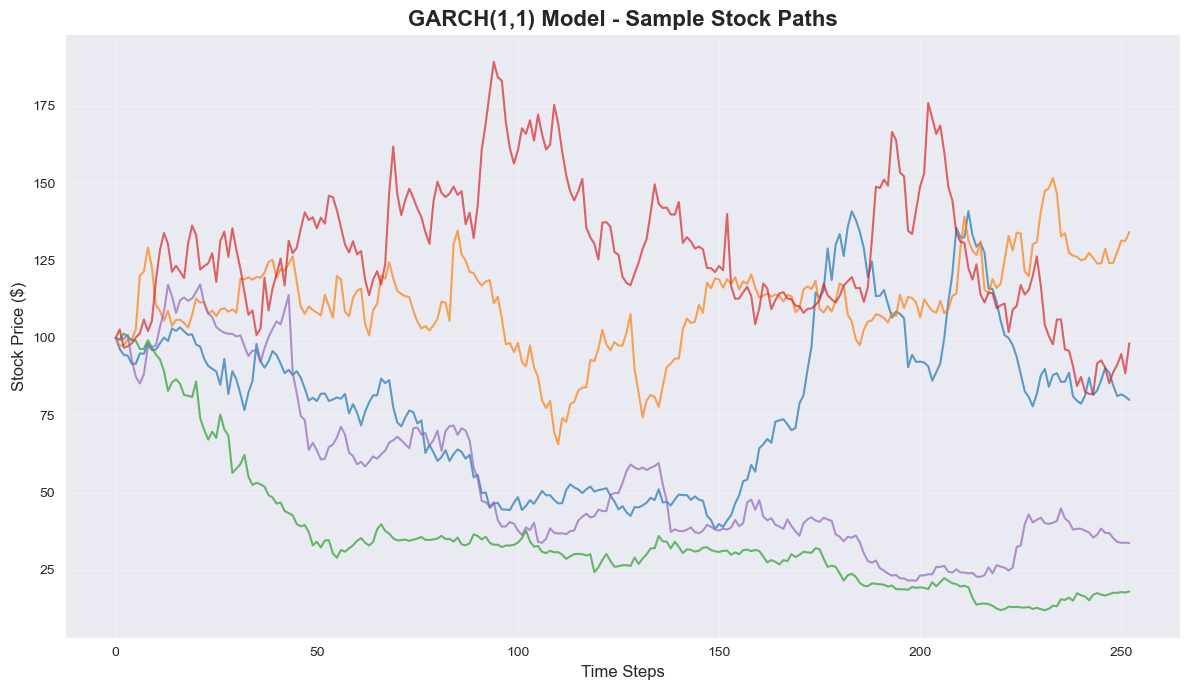

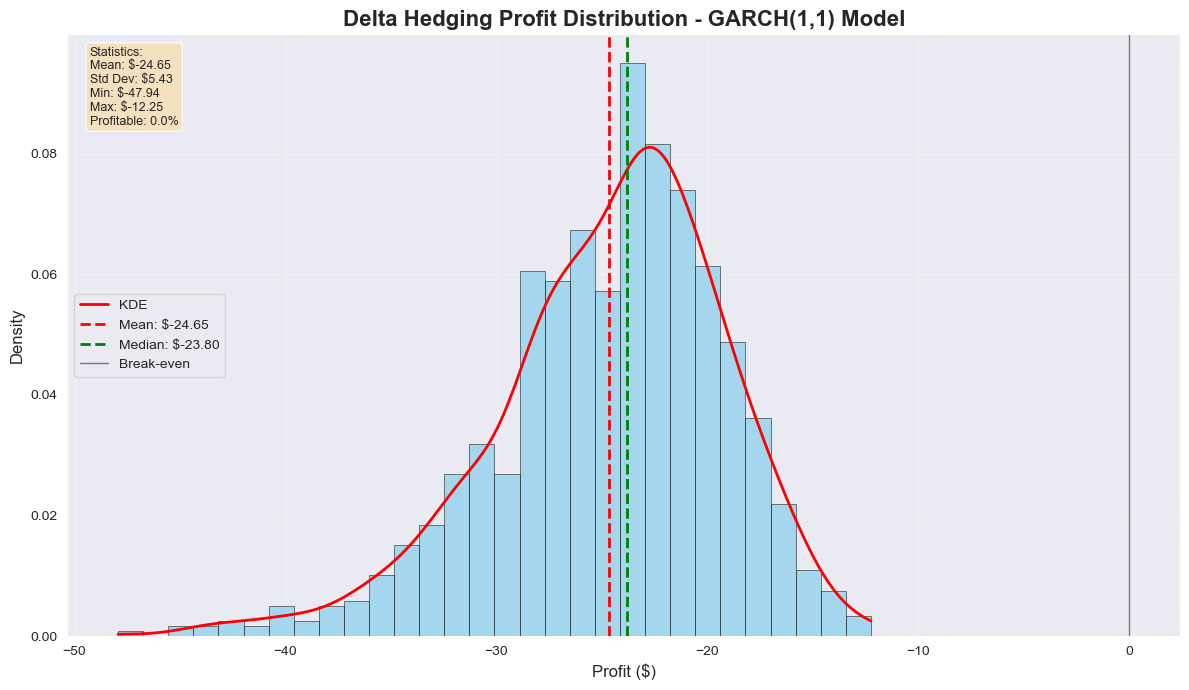

GARCH(1,1) Results:
  Mean Profit: $-24.65
  Std Deviation: $5.43
  Profitable Outcomes: 0.0%


In [35]:
print("\n2. GARCH(1,1) MODEL")
print("-" * 40)
np.random.seed(1205)
# Simulate GARCH paths
garch_paths, garch_vols = simulate_garch_paths(
    S0=S0, mu=mu, r=r, T=T, N=N, n_paths=n_paths,
    sigma0=0.2, omega=0.0001, alpha=0.1, beta=0.8
)

# Plot sample paths
plot_stock_paths(garch_paths, "GARCH(1,1) Model", n_display=5)

# Calculate hedging profits
garch_profits = delta_hedge_simulation(garch_paths, garch_vols, K, r, T)

# Plot profit distribution
plot_profit_distribution(garch_profits, "GARCH(1,1) Model")

print(f"GARCH(1,1) Results:")
print(f"  Mean Profit: ${np.mean(garch_profits):.2f}")
print(f"  Std Deviation: ${np.std(garch_profits):.2f}")
print(f"  Profitable Outcomes: {np.sum(np.array(garch_profits) > 0) / len(garch_profits) * 100:.1f}%")


3. HESTON STOCHASTIC VOLATILITY MODEL
----------------------------------------


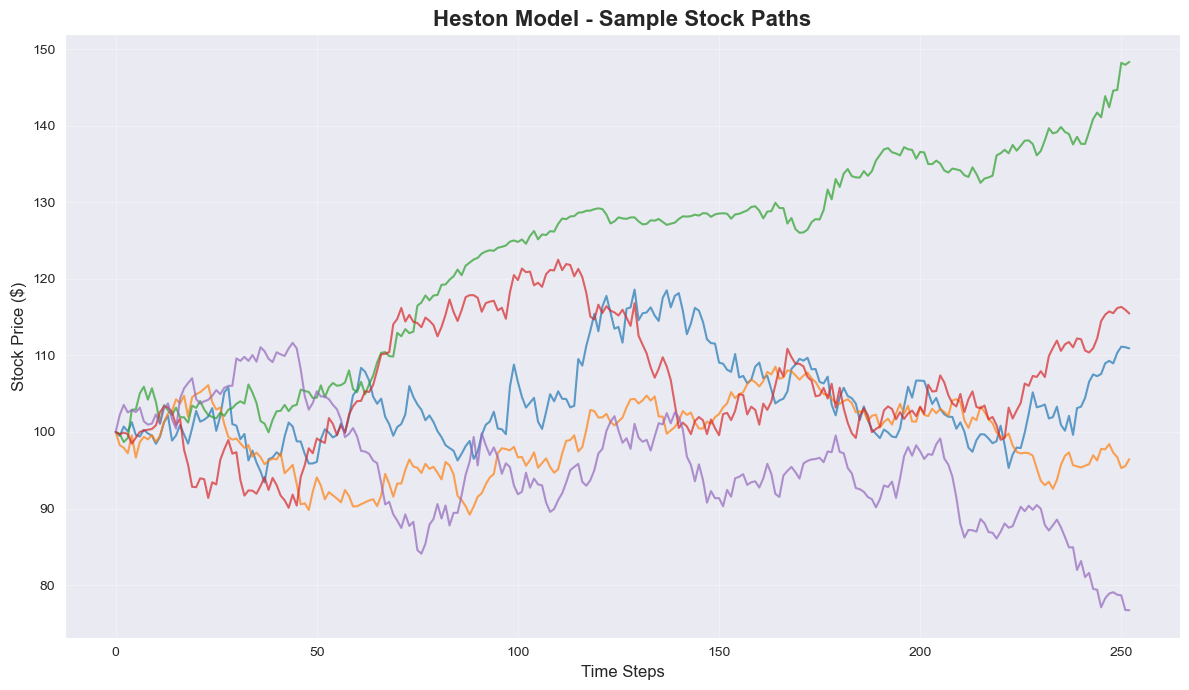

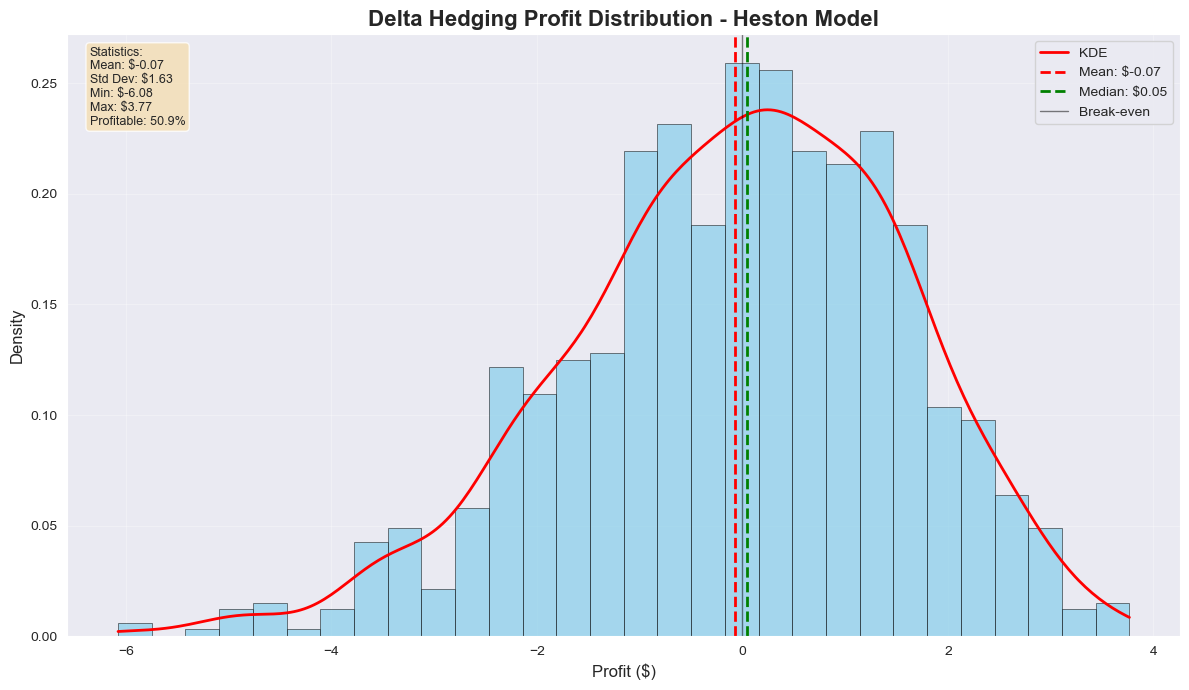

Heston Model Results:
  Mean Profit: $-0.07
  Std Deviation: $1.63
  Profitable Outcomes: 50.9%


In [36]:
print("\n3. HESTON STOCHASTIC VOLATILITY MODEL")
print("-" * 40)
np.random.seed(1205)
# Simulate Heston paths
heston_paths, heston_vols = simulate_heston_paths(
    S0=S0, v0=0.04, mu=mu, r=r, kappa=2.0, theta=0.04,
    xi=0.3, rho=-0.7, T=T, N=N, n_paths=n_paths
)

# Plot sample paths
plot_stock_paths(heston_paths, "Heston Model", n_display=5)

# Calculate hedging profits
heston_profits = delta_hedge_simulation(heston_paths, heston_vols, K, r, T)

# Plot profit distribution
plot_profit_distribution(heston_profits, "Heston Model")

print(f"Heston Model Results:")
print(f"  Mean Profit: ${np.mean(heston_profits):.2f}")
print(f"  Std Deviation: ${np.std(heston_profits):.2f}")
print(f"  Profitable Outcomes: {np.sum(np.array(heston_profits) > 0) / len(heston_profits) * 100:.1f}%")



4. SABR MODEL
----------------------------------------


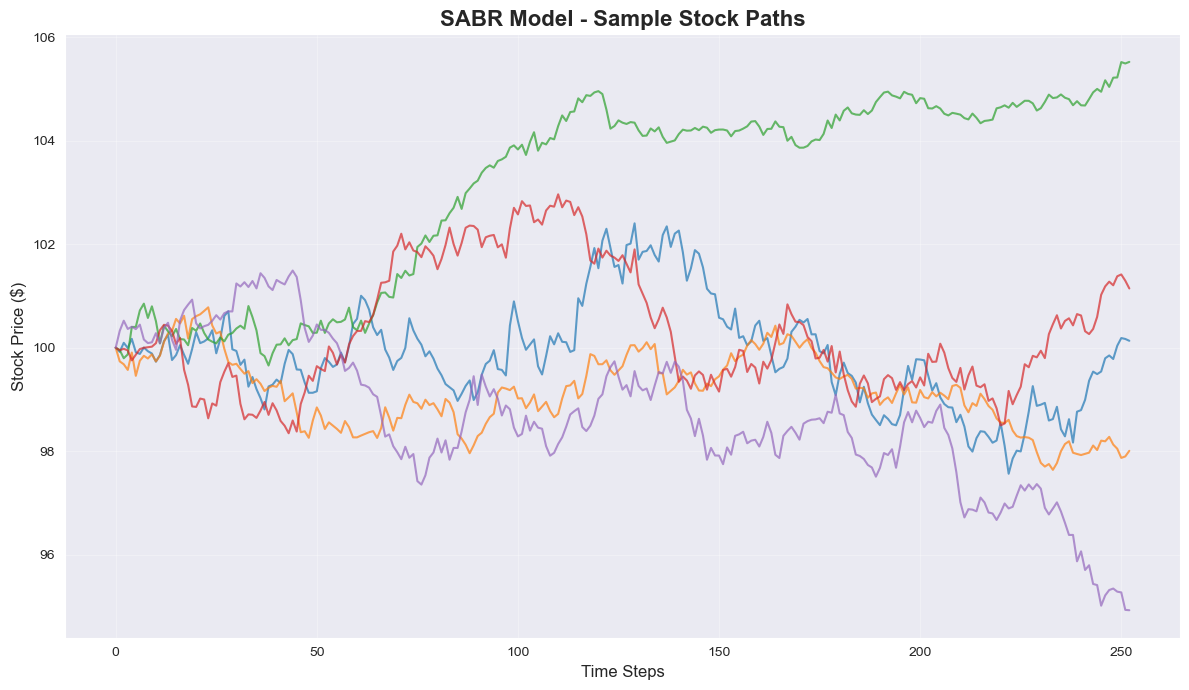

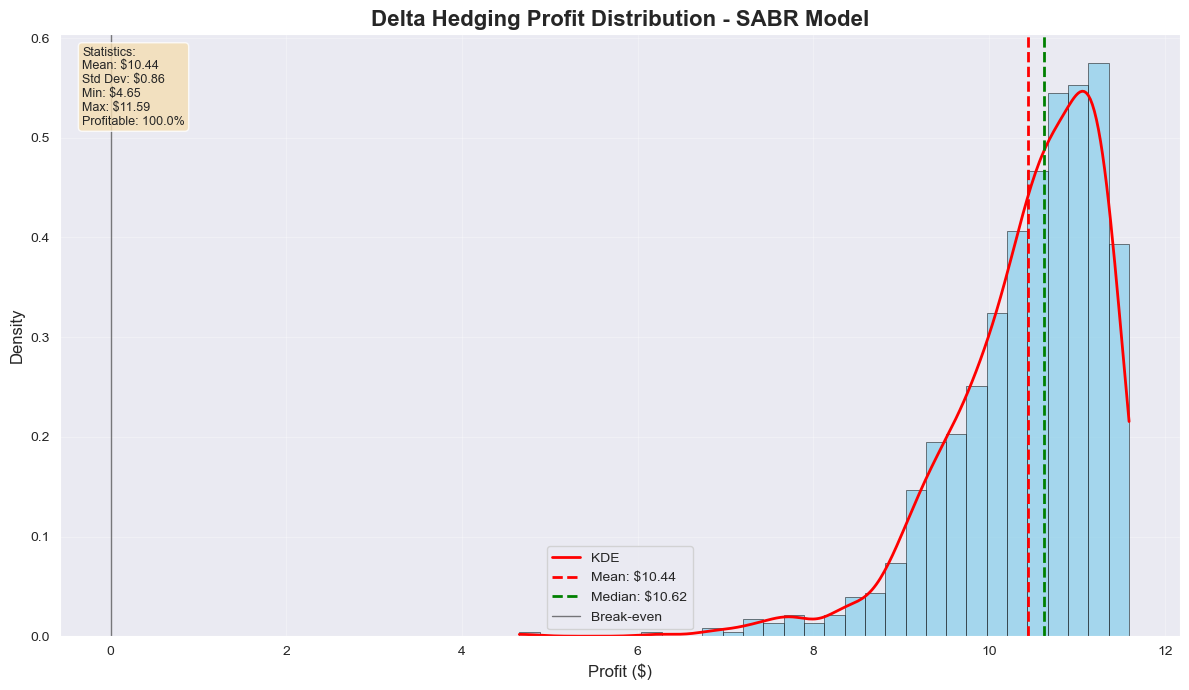

SABR Model Results:
  Mean Profit: $10.44
  Std Deviation: $0.86
  Profitable Outcomes: 100.0%


In [37]:
print("\n4. SABR MODEL")
print("-" * 40)
np.random.seed(1205)
# Simulate SABR paths
sabr_paths, sabr_vols = simulate_sabr_paths(
    F0=S0, alpha0=0.3, beta=0.5, nu=0.4, rho=-0.3, T=T, N=N, n_paths=n_paths
)

# Plot sample paths
plot_stock_paths(sabr_paths, "SABR Model", n_display=5)

# Calculate hedging profits
sabr_profits = delta_hedge_simulation(sabr_paths, sabr_vols, K, r, T)

# Plot profit distribution
plot_profit_distribution(sabr_profits, "SABR Model")

print(f"SABR Model Results:")
print(f"  Mean Profit: ${np.mean(sabr_profits):.2f}")
print(f"  Std Deviation: ${np.std(sabr_profits):.2f}")
print(f"  Profitable Outcomes: {np.sum(np.array(sabr_profits) > 0) / len(sabr_profits) * 100:.1f}%")


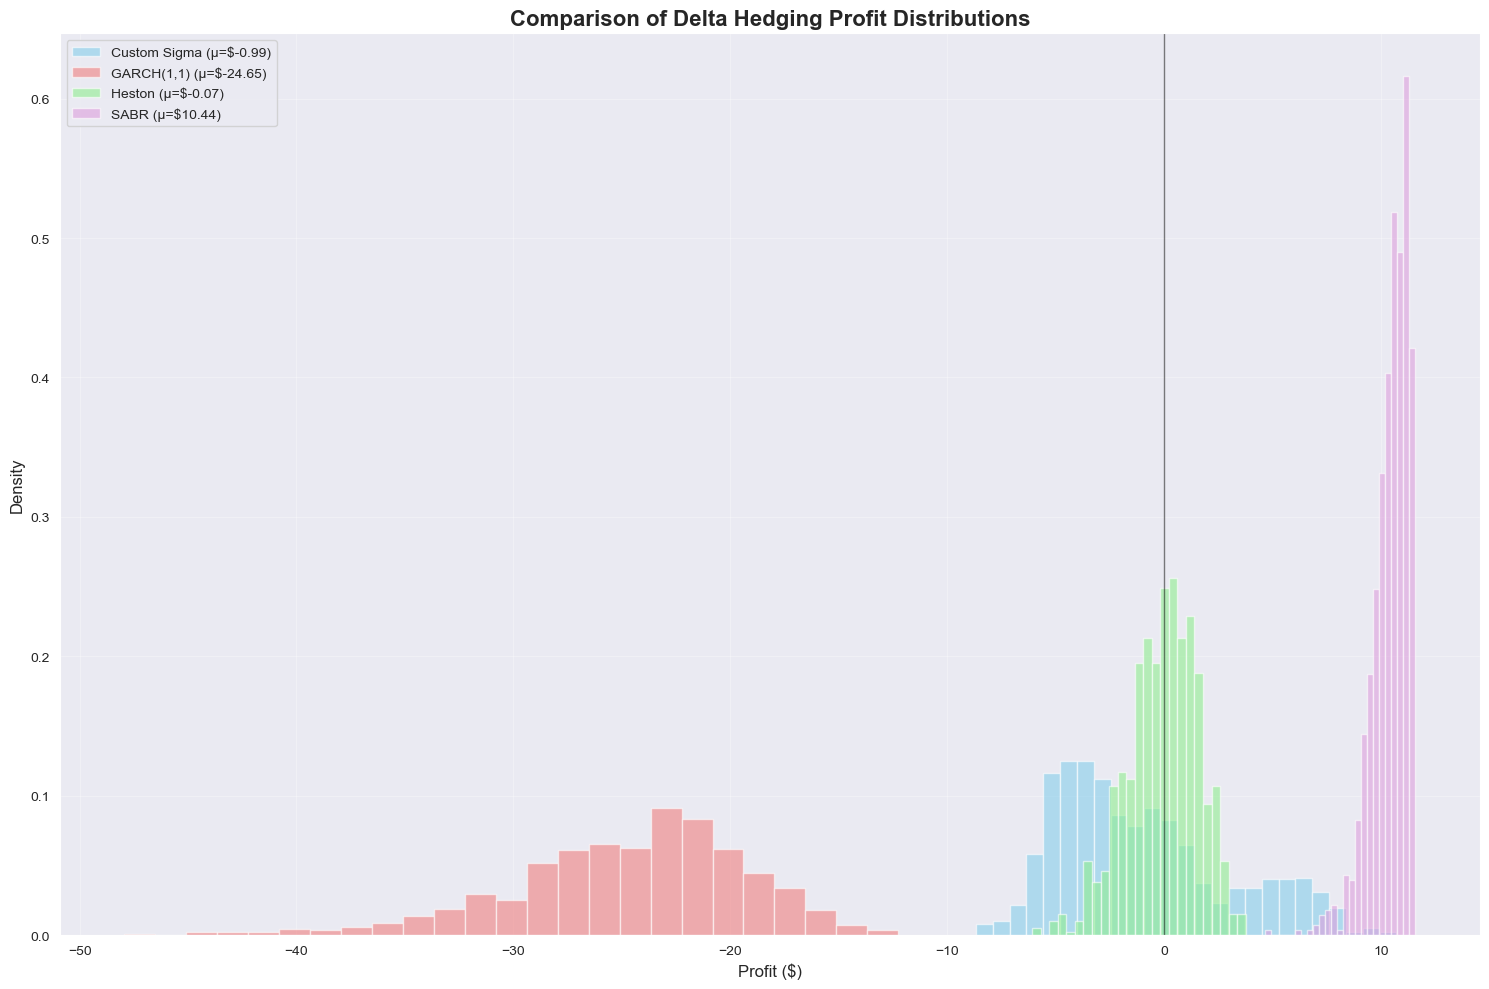

In [38]:
# Compare delta hedging profit distributions across all models
all_profits = {
    "Custom Sigma": custom_profits,
    "GARCH(1,1)": garch_profits,
    "Heston": heston_profits,
    "SABR": sabr_profits
}

compare_profit_distributions(all_profits)

## Summary and Discussion

This study evaluated the performance of **Black-Scholes delta hedging** under various **non-constant volatility models** using simulated asset paths. The results show that **none** of the stochastic volatility models could fully hedge the risk of the call option using the delta strategy alone. However, the nature of the hedging error varies by model:

### Key Observations:

- **Custom Sigma Model** (random volatility each step):
  - Most intuitive and least volatile among the four models.
  - Produced a **slightly negative average profit**, suggesting mild under-hedging.
  - Had the **highest fraction of profitable hedges** (~40%).

- **GARCH(1,1)**:
  - Exhibits **volatility clustering**, leading to more pronounced hedging errors during high-volatility episodes.
  - Lower average profits and higher standard deviation than the Custom model.
  - Demonstrated the **least hedging effectiveness**, with profits fluctuating significantly.

- **Heston Model**:
  - Introduced **mean-reverting stochastic variance**.
  - Hedging was more consistent compared to GARCH but still incurred frequent losses.
  - Profit distribution was tight but shifted negatively due to under-hedging during volatility spikes.

- **SABR Model**:
  - Common in interest rate and FX markets, adds **log-normal stochastic volatility**.
  - Generated a broad distribution of outcomes, with heavy tails and frequent large losses.
  - Profitable outcomes were relatively rare despite dynamic volatility.

### Conclusion:

The experiment highlights that **delta hedging is not sufficient** under stochastic volatility. More advanced techniques like **vega-hedging (sigma-hedging)** or **robust risk management** are necessary to deal with real-world volatility dynamics.

### Future Work:
- Implement and compare **vega-hedging strategies**
- Evaluate **transaction costs** during rebalancing
- Include **jump-diffusion** and **regime-switching** models for deeper realism
